In [1]:
import numpy as np
import pandas as pd
import random
from datetime import datetime
from scipy.integrate import quad
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import time
import mplleaflet
pd.set_option('display.max_columns',60)

## Step 1: Define Helper Functions

In [2]:
# csv_files_2017 = [('2017' + "%.2d" + '-citibike-tripdata.csv') % i for i in range(1, 13)]
# csv_files_2018 = [('2018' + "%.2d" + '-citibike-tripdata.csv') % i for i in range(1, 13)]
# csv_files_2019 = [('2019' + "%.2d" + '-citibike-tripdata.csv') % i for i in range(1, 13)]
# csv_files = csv_files_2017 + csv_files_2018 + csv_files_2019

In [3]:
# months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

In [4]:
def to_datetime(df):
    df1 = df.copy()
    df1['starttime'] = pd.to_datetime(df1['starttime'])
    df1['stoptime'] = pd.to_datetime(df1['stoptime'])
    df1['start_date'] = df1['starttime'].dt.date
    df1['start_time'] = df1['starttime'].dt.time
    df1['start_hour'] = df1['starttime'].dt.hour
    df1['start_min'] = df1['starttime'].dt.minute
    df1['start_year'] = df1['starttime'].dt.year
    df1['start_month'] = df1['starttime'].dt.month
    df1['start_dayofweek'] = df1['starttime'].dt.weekday   # Monday is 0, Sunday is 6
    #df1['start_dayofweek'] = df1['starttime'].dt.weekday_name  # The name of day in a week (e.g. Monday)
    df1['stop_date'] = df1['stoptime'].dt.date
    df1['stop_time'] = df1['stoptime'].dt.time
    df1['stop_hour'] = df1['stoptime'].dt.hour
    df1['stop_min'] = df1['stoptime'].dt.minute
    df1['stop_dayofweek'] = df1['stoptime'].dt.weekday
    return df1

In [5]:
def ignore_offpeak(df):
    df1 = df.copy()
    mask = df1['start_hour'].apply(lambda x: 5 <= x <= 22)
    return df1[mask]

In [6]:
# def lonlat2mile( lon_start,lat_start,lon_end, lat_end):
#     delta_y = (lat_end - lat_start) * 69
# #     def integrand( lat ):
# #         return np.cos( np.pi * lat / 180 ) * 69.172
# #     delta_x, xerr = quad(integrand, lat_start, lat_end )
#     delta_x = (lon_end - lon_start)*53
#     return np.abs( delta_x ) + np.abs( delta_y )
# # lonlat2mile(-73.983035,40.744449,-73.948813,40.778301)

In [7]:
def aggregated_data(df):
    # Define distance: if same start and end location, use average speed of 7.456mph to estimate distance.
    # If different locations, calculate Manhattan distance between two stations
    df['distance']=np.where(df['start_station_ID'] == df['end_station_ID'],df['trip_duration']*7.456/3600,
                            abs(df['start_station_longitude']-df['end_station_longitude'])*53+\
                            abs(df['start_station_latitude']-df['end_station_latitude'])*69)
    # Daily average of all stations for time-series analysis
    df_daily = df.groupby('start_date').agg({'trip_duration':['count','mean'],'distance':'mean'}).reset_index()
    df_daily.columns = ['start_date','trip_per_day','daily_avg_trip_duration','daily_avg_distance']
    df_daily_merged = df.merge(df_daily, how = 'left', on = 'start_date')
    # Hourly average for each station regardeless of days 
    df_hourly = df.groupby(['start_station_ID','start_hour']).\
    agg({'trip_duration':['count','mean'],'distance':'mean'}).reset_index()
    df_hourly.columns = ['start_station_ID','start_hour','trip_per_hour','hourly_avg_trip_duration','hourly_avg_distance']
    df_hourly_merged = df_daily_merged.merge(df_hourly, how = 'left', on = ['start_station_ID','start_hour'])
    # Calculate hourly trip counts, avg trip duration, and avg trip distance per station and merge to above df
    df_hourly_eachday = df.groupby(['start_station_ID','start_date','start_hour']).\
    agg({'trip_duration':['count','mean'],'distance':'mean'}).reset_index()
    df_hourly_eachday.columns = ['start_station_ID','start_date','start_hour','trip_per_hour_eachday','hourly_avg_trip_duration_eachday','hourly_avg_distance_eachday']
    df_hourly_eachday_merged = df_hourly_merged.merge(df_hourly_eachday, how = 'left', on = ['start_station_ID','start_date','start_hour'])
    return df_hourly_eachday_merged    

In [8]:
def merge_bikecount(df):
    # groupby start station ID, date and hour to get hourly counts of trips per start station
    checkout = df.groupby(['start_station_ID','start_date','start_hour'])['trip_duration'].count().reset_index()
    checkout.columns = ['start_station_ID','start_date','start_hour','checkout_counts']
    # groupby end station ID, date, and hour to get hourly counts of trips per end station 
    checkin = df.groupby(['end_station_ID','stop_date','stop_hour'])[['trip_duration']].count().reset_index()
    checkin.columns=['end_station_ID','stop_date','stop_hour','checkin_counts']
    # Join dataframe to get station checkin and checkout counts 
    temp = pd.merge(checkout, checkin,  how='outer', left_on=['start_station_ID','start_date','start_hour'], 
                    right_on = ['end_station_ID','stop_date','stop_hour'])
    temp['start_station_ID'] = temp['start_station_ID'].fillna(temp['end_station_ID'])
    temp['start_date'] = temp['start_date'].fillna(temp['stop_date'])
    temp['start_hour'] = temp['start_hour'].fillna(temp['stop_hour'])
    temp['checkout_counts'] = temp['checkout_counts'].fillna(0)
    temp['checkin_counts'] = temp['checkin_counts'].fillna(0)
    temp = temp.drop(['end_station_ID','stop_date','stop_hour'],axis=1)
    temp.columns=['station_ID','date','hour','checkout_counts','checkin_counts']
    temp['bike_added'] = temp['checkin_counts'] - temp['checkout_counts']
    # merge orginal dataframe to get hourly checkin/checkout information for both start and stop stations 
    df_temp_merged = pd.merge(df, temp,  how='left', left_on=['start_station_ID','start_date','start_hour'], 
         right_on = ['station_ID','date','hour']).drop(['station_ID','date','hour'],axis = 1)
    df_temp_merged = pd.merge(df_temp_merged, temp,  how='left', left_on=['end_station_ID','stop_date','stop_hour'], 
         right_on = ['station_ID','date','hour']).drop(['station_ID','date','hour'],axis = 1) 
    df_temp_merged = df_temp_merged.rename(columns={'checkout_counts_x':'start_station_checkout_counts',
                                                    'checkin_counts_x':'start_station_checkin_counts',
                                                    'bike_added_x':'start_station_bike_added', 
                                                    'checkout_counts_y':'end_station_checkout_counts',
                                                    'checkin_counts_y':'end_station_checkin_counts',
                                                    'bike_added_y':'end_station_bike_added'}) 
    return df_temp_merged
    

## Merge Datasets

In [9]:
# total_time = 0
# random.seed(0)
# path = '../Tripdata/'
# for i, csv in enumerate(csv_files):
#     start_time = time.time()
#     df_temp = pd.read_csv(path+csv)
#     df_temp.columns = ['trip_duration','starttime','stoptime','start_station_ID','start_station_name',
#                        'start_station_latitude','start_station_longitude','end_station_ID','end_station_name',
#                        'end_station_latitude','end_station_longitude','bike_ID','user_type','birth_year','gender']
#     df_temp = df_temp.loc[df_temp['trip_duration']<= 24*3600] # remove trips that are longer than 1 day 
#     df_temp = df_temp.loc[(df_temp['start_station_latitude']>40) & (df_temp['start_station_latitude']<41)] # remove areas that are not in NYC (equator and montreal)
#     df_temp = to_datetime(df_temp)
#     df_temp = ignore_offpeak(df_temp)
#     df_temp = merge_bikecount(df_temp)
#     df_temp = aggregated_data(df_temp)
    
#     # take a 5% subset of monthly file for analysis and another 5% of the remaining dataset as test dataset for ML
#     rows = len(df_temp)
#     size = int(rows/20)
#     selected_idx = random.sample(range(1,rows), size)
#     skip_idx = list(set(df_temp.index)-set(selected_idx))
#     test_idx = random.sample(skip_idx,int(len(skip_idx)/20))
#     df_train = df_temp.iloc[selected_idx,:]
#     df_test = df_temp.iloc[test_idx,:]
    
#     # save train and test datset 
#     df_train.to_csv(months[i%12] + csv[:4] + 'train.csv')
#     df_test.to_csv(months[i%12] + csv[:4] + 'test.csv')
#     print('Finishing data extraction from ' + csv)
#     timeSpent = time.time() - start_time
#     print('This iteration uses %.2f'%(timeSpent))
#     total_time += timeSpent
#     print(total_time)

In [10]:
# train_list = []
# test_list = []
# for i, csv in enumerate(csv_files):
#     train_list.append(months[i%12] + csv[:4] + 'train.csv')
#     test_list.append(months[i%12] + csv[:4] + 'test.csv')

In [11]:
# # Merge all months train.csv into one train dataframe
# train_df = pd.DataFrame()
# for i in range(len(train_list)):
#     temp_df = pd.read_csv(train_list[i], index_col = 0)
#     train_df = pd.concat([train_df, temp_df], axis = 0)
#     print('Finished ' + str(i) + ' element')
# train_df.to_csv('train.csv')

In [12]:
# #Merge all months test.csv into one test dataframe
# test_df = pd.DataFrame()
# for i in range(len(test_list)):
#     temp_df = pd.read_csv(test_list[i], index_col = 0)
#     test_df = pd.concat([test_df, temp_df], axis = 0)
#     print('Finished ' + str(i) + ' element')
# test_df.to_csv('test.csv')

In [13]:
train_df = pd.read_csv('train.csv', index_col = 0)

C:\Users\zhang\Anaconda3\lib\site-packages\numpy\lib\arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [14]:
test_df = pd.read_csv('test.csv', index_col = 0)

### Merge Weather Dataset

In [15]:
weather = pd.read_csv('weather.csv',index_col = 0).reset_index()
weather = weather.fillna(0)
weather['DATE'] = pd.to_datetime(weather['DATE'])
weather['TAVG'] = (weather['TMIN']+weather['TMAX'])/2
weather['HasPRCP'] = [1 if x !=0 else 0 for x in weather['PRCP']]
weather['HasSNOW'] = [1 if x !=0 else 0 for x in weather['SNOW']]

In [16]:
train_df['start_date'] = pd.to_datetime(train_df['start_date'])
train_df_weather = train_df.merge(weather,how='left',
                                  left_on = 'start_date', right_on = 'DATE').drop(['DATE'],axis=1)

In [17]:
# test_df['start_date'] = pd.to_datetime(test_df['start_date'])
# test_df_weather = test_df.merge(weather,how='left',
#                                   left_on = 'start_date', right_on = 'DATE').drop(['DATE'],axis=1)

### Merge Bike Dataset

In [18]:
# bike_files_2017 = [('bikeshare_nyc_raw_2017'+'%.2d'+'.csv') % i for i in range(1, 13)]
# bike_files_2018 = [('bikeshare_nyc_raw_2018'+'%.2d'+'.csv') % i for i in range(1, 13)]
# bike_files_2019 = [('bikeshare_nyc_raw_2019'+'%.2d'+'.csv') % i for i in range(1, 5)]
# bike_files = bike_files_2017 + bike_files_2018 + bike_files_2019

In [19]:
# dock_df = pd.DataFrame()
# for i in bike_files: 
#     bike_temp = pd.read_csv(i,sep='\t',usecols=['dock_id', 'dock_name', "date", "tot_docks"])
#     dock_df = pd.concat([dock_df,bike_temp],axis = 0)
#     print('Finished %s'%i)

In [20]:
# dockdf = dock_df.groupby(['dock_name','date'])['tot_docks'].agg({lambda x: x.iloc[0]}).reset_index()
# dockdf.columns=['start_station_name','start_date','tot_docks']
# dockdf['start_date']=pd.to_datetime(dockdf['start_date'])
# dockdf.to_csv('total_docks.csv')

In [21]:
dockdf = pd.read_csv('total_docks.csv',index_col = 0)
dockdf['start_date']=pd.to_datetime(dockdf['start_date'])

In [22]:
dockdf_merged = train_df_weather.merge(dockdf,how='left',on=['start_station_name','start_date'])
dockdf_merged

,trip_duration,starttime,stoptime,start_station_ID,start_station_name,start_station_latitude,start_station_longitude,end_station_ID,end_station_name,end_station_latitude,end_station_longitude,bike_ID,user_type,birth_year,gender,start_date,start_time,start_hour,start_min,start_year,start_month,start_dayofweek,stop_date,stop_time,stop_hour,stop_min,stop_dayofweek,start_station_checkout_counts,start_station_checkin_counts,start_station_bike_added,end_station_checkout_counts,end_station_checkin_counts,end_station_bike_added,distance,trip_per_day,daily_avg_trip_duration,daily_avg_distance,trip_per_hour,hourly_avg_trip_duration,hourly_avg_distance,trip_per_hour_eachday,hourly_avg_trip_duration_eachday,hourly_avg_distance_eachday,AWND,PRCP,SNOW,SNWD,TMAX,TMIN,Fog,Heavy_Fog,Thunder,Hail,Glaze,Haze,TAVG,HasPRCP,HasSNOW,tot_docks
0,538,2017-01-19 18:46:58,2017-01-19 18:55:56,519.0,Pershing Square North,40.751873,-73.977706,515.0,W 43 St & 10 Ave,40.760094,-73.994618,16671,Subscriber,1977.0,1,2017-01-19,18:46:58,18,46,2017,1,3,2017-01-19,18:55:56,18,55,3,92.0,72.0,-20.0,4.0,12.0,8.0,1.463633,35672,708.974658,1.420254,1147.0,764.414124,1.556025,92.0,740.130435,1.490564,3.58,0.00,0.0,0.0,49,39,0.0,0.0,0.0,0.0,0.0,0.0,44.0,0,0,61.0
1,538,2017-01-21 11:13:23,2017-01-21 11:22:22,116.0,W 17 St & 8 Ave,40.741776,-74.001497,503.0,E 20 St & Park Ave,40.738274,-73.987520,25795,Subscriber,1966.0,2,2017-01-21,11:13:23,11,13,2017,1,5,2017-01-21,11:22:22,11,22,5,7.0,16.0,9.0,5.0,9.0,4.0,0.982443,25216,829.179806,1.420891,80.0,649.837500,1.176237,7.0,932.285714,1.553252,3.80,0.00,0.0,0.0,49,41,1.0,0.0,0.0,0.0,0.0,1.0,45.0,0,0,NaN
2,996,2017-01-04 08:35:33,2017-01-04 08:52:09,301.0,E 2 St & Avenue B,40.722174,-73.983688,146.0,Hudson St & Reade St,40.716250,-74.009106,17358,Subscriber,1986.0,2,2017-01-04,08:35:33,8,35,2017,1,2,2017-01-04,08:52:09,8,52,2,17.0,3.0,-14.0,6.0,5.0,-1.0,1.755941,33455,714.582663,1.407101,385.0,829.384416,1.601648,17.0,857.823529,1.569631,8.05,0.00,0.0,0.0,52,34,1.0,0.0,0.0,0.0,0.0,1.0,43.0,0,0,NaN
3,1656,2017-01-13 20:13:23,2017-01-13 20:40:59,483.0,E 12 St & 3 Ave,40.732233,-73.988900,3246.0,Montague St & Clinton St,40.694281,-73.992300,26555,Subscriber,1980.0,1,2017-01-13,20:13:23,20,13,2017,1,4,2017-01-13,20:40:59,20,40,4,6.0,4.0,-2.0,1.0,2.0,1.0,2.798899,32550,705.899816,1.388478,160.0,580.875000,1.061558,6.0,649.833333,1.235200,7.16,0.00,0.0,0.0,62,32,0.0,0.0,0.0,0.0,0.0,0.0,47.0,0,0,NaN
4,203,2017-01-25 18:18:56,2017-01-25 18:22:20,525.0,W 34 St & 11 Ave,40.755942,-74.002116,458.0,11 Ave & W 27 St,40.751396,-74.005226,16993,Subscriber,1975.0,2,2017-01-25,18:18:56,18,18,2017,1,2,2017-01-25,18:22:20,18,22,2,8.0,3.0,-5.0,6.0,6.0,0.0,0.478460,36154,726.042015,1.407985,102.0,649.205882,1.358876,8.0,655.500000,1.074977,6.71,0.00,0.0,0.0,51,36,0.0,0.0,0.0,0.0,0.0,0.0,43.5,0,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2625373,1027,2019-12-24 14:09:50.970,2019-12-24 14:26:58.170,3457.0,E 58 St & Madison Ave,40.763026,-73.972095,3132.0,E 59 St & Madison Ave,40.763505,-73.971092,20603,Subscriber,1993.0,1,2019-12-24,14:09:50.970000,14,9,2019,12,1,2019-12-24,14:26:58.170000,14,26,1,3.0,2.0,-1.0,3.0,2.0,-1.0,0.086227,24813,727.257365,1.285090,99.0,734.747475,1.209281,3.0,1297.666667,0.701660,5.82,0.00,0.0,0.0,47,36,0.0,0.0,0.0,0.0,0.0,0.0,41.5,0,0,NaN
2625374,533,2019-12-11 13:49:46.927,2019-12-11 13:58:40.081,293.0,Lafayette St & E 8 St,40.730207,-73.991026,446.0,W 24 St & 7 Ave,40.744876,-73.995299,33310,Subscriber,1984.0,1,2019-12-11,13:49:46.927000,13,49,2019,12,2,2019-12-11,13:58:40.081000,13,58,2,10.0,11.0,1.0,11.0,9.0,-2.0,1.238658,37143,669.022938,1.261227,265.0,539.305660,0.932227,10.0,698.200000,1.162153,6.26,0.26,0.2,0.0,40,31,1.0,0.0,0.0,0.0,0.0,0.0,35.5,1,1,NaN
2625375,320,2019-12-18 18:06:09.456,2019-12-18 18:11:30.131,437

In [23]:
dock_station = pd.read_csv('dock_station.csv',usecols=['start_station_name','capacity'])
dock_station

,start_station_name,capacity
0,Broadway & E 22 St,39
1,8 Ave & W 31 St,19
2,W 52 St & 11 Ave,55
3,Franklin St & W Broadway,33
4,St James Pl & Pearl St,27
...,...,...
930,Sands St Gate,19
931,West End Ave & W 78 St,39
932,Pearl St & Peck Slip,45
933,Willoughby St & Ashland Pl,31


In [24]:
dock_station_merged = dockdf_merged.merge(dock_station,how='left',on=['start_station_name'])
print(dock_station_merged.tot_docks.isna().sum())
mask1 = (dock_station_merged['tot_docks']<=10) & (dock_station_merged['capacity']>20)
dock_station_merged.tot_docks[mask1] = np.nan
print(dock_station_merged.tot_docks.isna().sum())
dock_station_merged['tot_docks'] = dock_station_merged['tot_docks'].fillna(dock_station_merged['capacity'])
dock_station_merged.tot_docks.isna().sum()
# drop capacity column
# dock_station_merged.drop(['capacity'],axis=1)

2465455
2466267


C:\Users\zhang\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


165082

In [25]:
dock_station_merged

,trip_duration,starttime,stoptime,start_station_ID,start_station_name,start_station_latitude,start_station_longitude,end_station_ID,end_station_name,end_station_latitude,end_station_longitude,bike_ID,user_type,birth_year,gender,start_date,start_time,start_hour,start_min,start_year,start_month,start_dayofweek,stop_date,stop_time,stop_hour,stop_min,stop_dayofweek,start_station_checkout_counts,start_station_checkin_counts,start_station_bike_added,end_station_checkout_counts,end_station_checkin_counts,end_station_bike_added,distance,trip_per_day,daily_avg_trip_duration,daily_avg_distance,trip_per_hour,hourly_avg_trip_duration,hourly_avg_distance,trip_per_hour_eachday,hourly_avg_trip_duration_eachday,hourly_avg_distance_eachday,AWND,PRCP,SNOW,SNWD,TMAX,TMIN,Fog,Heavy_Fog,Thunder,Hail,Glaze,Haze,TAVG,HasPRCP,HasSNOW,tot_docks,capacity
0,538,2017-01-19 18:46:58,2017-01-19 18:55:56,519.0,Pershing Square North,40.751873,-73.977706,515.0,W 43 St & 10 Ave,40.760094,-73.994618,16671,Subscriber,1977.0,1,2017-01-19,18:46:58,18,46,2017,1,3,2017-01-19,18:55:56,18,55,3,92.0,72.0,-20.0,4.0,12.0,8.0,1.463633,35672,708.974658,1.420254,1147.0,764.414124,1.556025,92.0,740.130435,1.490564,3.58,0.00,0.0,0.0,49,39,0.0,0.0,0.0,0.0,0.0,0.0,44.0,0,0,61.0,69.0
1,538,2017-01-21 11:13:23,2017-01-21 11:22:22,116.0,W 17 St & 8 Ave,40.741776,-74.001497,503.0,E 20 St & Park Ave,40.738274,-73.987520,25795,Subscriber,1966.0,2,2017-01-21,11:13:23,11,13,2017,1,5,2017-01-21,11:22:22,11,22,5,7.0,16.0,9.0,5.0,9.0,4.0,0.982443,25216,829.179806,1.420891,80.0,649.837500,1.176237,7.0,932.285714,1.553252,3.80,0.00,0.0,0.0,49,41,1.0,0.0,0.0,0.0,0.0,1.0,45.0,0,0,50.0,50.0
2,996,2017-01-04 08:35:33,2017-01-04 08:52:09,301.0,E 2 St & Avenue B,40.722174,-73.983688,146.0,Hudson St & Reade St,40.716250,-74.009106,17358,Subscriber,1986.0,2,2017-01-04,08:35:33,8,35,2017,1,2,2017-01-04,08:52:09,8,52,2,17.0,3.0,-14.0,6.0,5.0,-1.0,1.755941,33455,714.582663,1.407101,385.0,829.384416,1.601648,17.0,857.823529,1.569631,8.05,0.00,0.0,0.0,52,34,1.0,0.0,0.0,0.0,0.0,1.0,43.0,0,0,58.0,58.0
3,1656,2017-01-13 20:13:23,2017-01-13 20:40:59,483.0,E 12 St & 3 Ave,40.732233,-73.988900,3246.0,Montague St & Clinton St,40.694281,-73.992300,26555,Subscriber,1980.0,1,2017-01-13,20:13:23,20,13,2017,1,4,2017-01-13,20:40:59,20,40,4,6.0,4.0,-2.0,1.0,2.0,1.0,2.798899,32550,705.899816,1.388478,160.0,580.875000,1.061558,6.0,649.833333,1.235200,7.16,0.00,0.0,0.0,62,32,0.0,0.0,0.0,0.0,0.0,0.0,47.0,0,0,34.0,34.0
4,203,2017-01-25 18:18:56,2017-01-25 18:22:20,525.0,W 34 St & 11 Ave,40.755942,-74.002116,458.0,11 Ave & W 27 St,40.751396,-74.005226,16993,Subscriber,1975.0,2,2017-01-25,18:18:56,18,18,2017,1,2,2017-01-25,18:22:20,18,22,2,8.0,3.0,-5.0,6.0,6.0,0.0,0.478460,36154,726.042015,1.407985,102.0,649.205882,1.358876,8.0,655.500000,1.074977,6.71,0.00,0.0,0.0,51,36,0.0,0.0,0.0,0.0,0.0,0.0,43.5,0,0,56.0,56.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2625373,1027,2019-12-24 14:09:50.970,2019-12-24 14:26:58.170,3457.0,E 58 St & Madison Ave,40.763026,-73.972095,3132.0,E 59 St & Madison Ave,40.763505,-73.971092,20603,Subscriber,1993.0,1,2019-12-24,14:09:50.970000,14,9,2019,12,1,2019-12-24,14:26:58.170000,14,26,1,3.0,2.0,-1.0,3.0,2.0,-1.0,0.086227,24813,727.257365,1.285090,99.0,734.747475,1.209281,3.0,1297.666667,0.701660,5.82,0.00,0.0,0.0,47,36,0.0,0.0,0.0,0.0,0.0,0.0,41.5,0,0,46.0,46.0
2625374,533,2019-12-11 13:49:46.927,2019-12-11 13:58:40.081,293.0,Lafayette St & E 8 St,40.730207,-73.991026,446.0,W 24 St & 7 Ave,40.744876,-73.995299,33310,Subscriber,1984.0,1,2019-12-11,13:49:46.927000,13,49,2019,12,2,2019-12-11,13:58:40.081000,13,58,2,10.0,11.0,1.0,11.0,9.0,-2.0,1.238658,37143,669.022938,1.261227,265.0,539.305660,0.932227,10.0,698.200000,1.162153,6.26,0.26,0.2,0.0,40,31,1.0,0.0,0.0,0.0,0.0,0.0,35.5,1,1,55.0,55.0
2625375,3

In [26]:
# Impute missing values in tot_docks for all stations
missing = list(dock_station_merged.loc[dock_station_merged.tot_docks.isna()]['start_station_ID'].unique())
for i in missing:
    missingrows = len(dock_station_merged.loc[(dock_station_merged['start_station_ID']==i) & (dock_station_merged['tot_docks'].isna())])
    if len(dock_station_merged.loc[(dock_station_merged['start_station_ID']==i)]) != missingrows:
        mask =  (dock_station_merged['start_station_ID']==i) & (dock_station_merged['tot_docks'].isna())
        med = dock_station_merged.loc[(dock_station_merged['start_station_ID']==i)]['tot_docks'].median()
        dock_station_merged.loc[mask,'tot_docks']=dock_station_merged.loc[mask,'tot_docks'].fillna(med) 
dock_station_merged.loc[dock_station_merged.tot_docks.isna()]['start_station_ID'].nunique()

49

In [27]:
# Name is not matching or station is obselete 
missing1 = list(dock_station_merged.loc[dock_station_merged.tot_docks.isna()]['start_station_ID'].unique())
dock_station_merged.loc[dock_station_merged['start_station_ID'].isin(missing1)]

,trip_duration,starttime,stoptime,start_station_ID,start_station_name,start_station_latitude,start_station_longitude,end_station_ID,end_station_name,end_station_latitude,end_station_longitude,bike_ID,user_type,birth_year,gender,start_date,start_time,start_hour,start_min,start_year,start_month,start_dayofweek,stop_date,stop_time,stop_hour,stop_min,stop_dayofweek,start_station_checkout_counts,start_station_checkin_counts,start_station_bike_added,end_station_checkout_counts,end_station_checkin_counts,end_station_bike_added,distance,trip_per_day,daily_avg_trip_duration,daily_avg_distance,trip_per_hour,hourly_avg_trip_duration,hourly_avg_distance,trip_per_hour_eachday,hourly_avg_trip_duration_eachday,hourly_avg_distance_eachday,AWND,PRCP,SNOW,SNWD,TMAX,TMIN,Fog,Heavy_Fog,Thunder,Hail,Glaze,Haze,TAVG,HasPRCP,HasSNOW,tot_docks,capacity
667,337,2017-01-11 18:37:54,2017-01-11 18:43:32,3265.0,E 2 St & 2 Ave E,40.724563,-73.989444,295.0,Pike St & E Broadway,40.714067,-73.992939,17596,Subscriber,1938.0,1,2017-01-11,18:37:54,18,37,2017,1,2,2017-01-11,18:43:32,18,43,2,4.0,8.0,4.0,4.0,5.0,1.0,0.909529,32036,712.750936,1.415919,54.0,470.925926,0.913873,4.0,622.000000,1.423738,5.82,0.52,0.0,0.0,52,42,1.0,0.0,0.0,0.0,0.0,0.0,47.0,1,0,NaN,NaN
729,314,2017-01-26 11:29:17,2017-01-26 11:34:31,3265.0,E 2 St & 2 Ave E,40.724563,-73.989444,303.0,Mercer St & Spring St,40.723627,-73.999496,15350,Subscriber,1984.0,1,2017-01-26,11:29:17,11,29,2017,1,3,2017-01-26,11:34:31,11,34,3,3.0,1.0,-2.0,2.0,3.0,1.0,0.597356,32084,685.643872,1.364001,53.0,685.509434,1.335296,3.0,543.333333,1.157725,6.71,0.02,0.0,0.0,56,43,0.0,0.0,0.0,0.0,0.0,0.0,49.5,1,0,NaN,NaN
984,1387,2017-01-05 17:38:34,2017-01-05 18:01:41,3264.0,E 61 St & Park Ave,40.764210,-73.969105,379.0,W 31 St & 7 Ave,40.749156,-73.991600,14650,Subscriber,1982.0,1,2017-01-05,17:38:34,17,38,2017,1,3,2017-01-05,18:01:41,18,1,3,6.0,2.0,-4.0,34.0,32.0,-2.0,2.230988,27779,651.397782,1.323058,27.0,714.481481,1.391404,6.0,902.000000,1.422317,7.83,0.00,0.0,0.0,34,27,0.0,0.0,0.0,0.0,0.0,0.0,30.5,0,0,NaN,NaN
2218,1897,2017-01-06 17:27:53,2017-01-06 17:59:31,255.0,NYCBS Depot - SSP,40.646768,-74.016510,467.0,Dean St & 4 Ave,40.683125,-73.978951,25326,Subscriber,1988.0,1,2017-01-06,17:27:53,17,27,2017,1,4,2017-01-06,17:59:31,17,59,4,2.0,0.0,-2.0,3.0,4.0,1.0,4.499233,23575,660.306596,1.284048,10.0,2669.500000,6.378892,2.0,2397.500000,5.292108,4.70,0.05,1.2,1.2,33,25,1.0,0.0,0.0,0.0,0.0,1.0,29.0,1,1,NaN,NaN
3023,238,2017-01-17 06:48:32,2017-01-17 06:52:30,3265.0,E 2 St & 2 Ave E,40.724563,-73.989444,251.0,Mott St & Prince St,40.723180,-73.994800,19047,Subscriber,1976.0,1,2017-01-17,06:48:32,6,48,2017,1,1,2017-01-17,06:52:30,6,52,1,3.0,1.0,-2.0,0.0,1.0,1.0,0.379372,18190,661.653161,1.369798,25.0,539.920000,1.089815,3.0,315.000000,0.526011,4.92,0.35,0.0,0.0,42,38,1.0,0.0,0.0,0.0,0.0,1.0,40.0,1,0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2624691,1426,2019-12-29 05:17:14.520,2019-12-29 05:41:01.218,3908.0,Battery Pl & Greenwich St,40.704630,-74.015070,491.0,E 24 St & Park Ave S,40.740964,-73.986022,20865,Customer,1969.0,0,2019-12-29,05:17:14.520000,5,17,2019,12,6,2019-12-29,05:41:01.218000,5,41,6,6.0,0.0,-6.0,6.0,6.0,0.0,4.046565,16598,829.117966,1.319863,7.0,1271.285714,3.541515,6.0,1438.000000,4.046565,4.92,0.25,0.0,0.0,44,39,1.0,0.0,0.0,0.0,0.0,0.0,41.5,1,0,NaN,NaN
2624706,547,2019-12-07 18:48:48.248,2019-12-07 18:57:55.311,3908.0,Battery Pl & Greenwich St,40.704630,-74.015070,331.0,Pike St & Monroe St,40.711731,-73.991930,41354,Subscriber,1991.0,1,2019-12-07,18:48:48.248000,18,48,2019,12,5,2019-12-07,18:57:55.311000,18,57,5,2.0,4.0,2.0,6.0,6.0,0.0,1.716371,32371,754.944549,1.280923,147.0,1135.102041,2.457249,2.0,403.000000,1.117060,6.93,0.00,0.0,0.0,38,30,0.0,0.0,0.0,0.0,0.0,0.0,34.0,0,0,NaN,NaN
2625129,2554,2019-12

In [28]:
# Sanity check and overwrite errors in dock capacity 
mask = dock_station_merged['tot_docks']!=0 
dock_station_merged = dock_station_merged[mask]# remove stations that have 0 tot_docks
mask1 = (dock_station_merged['tot_docks']==1) & (dock_station_merged['start_station_ID']==3459)
dock_station_merged['tot_docks'][mask1]=34 ### impute tot_docks due to nonsense total_docks for a few entries
mask2 = (dock_station_merged['tot_docks']==7) & (dock_station_merged['start_station_ID']==3255)
dock_station_merged['tot_docks'][mask2]=19 ### impute tot_docks due to nonsense total_docks for a few entries
mask3 = (dock_station_merged['tot_docks']==3) & (dock_station_merged['start_station_ID']==3467)
dock_station_merged['tot_docks'][mask3]=44 ### impute tot_docks due to nonsense total_docks for a few entries

C:\Users\zhang\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
C:\Users\zhang\Anaconda3\lib\site-packages\pandas\core\generic.py:9114: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)
C:\Users\zhang\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3326: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exec(code_obj, self.user_global_ns, self.user_n

In [29]:
# Define a new column: percent_usage for each station 
dock_station_merged['Percent_usage'] = (dock_station_merged['start_station_checkin_counts']+dock_station_merged['start_station_checkout_counts'])/dock_station_merged['tot_docks']
dock_station_merged[['Percent_usage']].describe()

C:\Users\zhang\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Percent_usage
count,2.600360e+06
mean,6.256518e-01
std,6.312288e-01
min,1.265823e-02
25%,2.380952e-01
50%,4.516129e-01
75%,8.000000e-01
max,1.433333e+01


In [30]:
dock_station_merged.loc[dock_station_merged['Percent_usage']>13]#['start_station_ID'].unique()

,trip_duration,starttime,stoptime,start_station_ID,start_station_name,start_station_latitude,start_station_longitude,end_station_ID,end_station_name,end_station_latitude,end_station_longitude,bike_ID,user_type,birth_year,gender,start_date,start_time,start_hour,start_min,start_year,start_month,start_dayofweek,stop_date,stop_time,stop_hour,stop_min,stop_dayofweek,start_station_checkout_counts,start_station_checkin_counts,start_station_bike_added,...,end_station_checkin_counts,end_station_bike_added,distance,trip_per_day,daily_avg_trip_duration,daily_avg_distance,trip_per_hour,hourly_avg_trip_duration,hourly_avg_distance,trip_per_hour_eachday,hourly_avg_trip_duration_eachday,hourly_avg_distance_eachday,AWND,PRCP,SNOW,SNWD,TMAX,TMIN,Fog,Heavy_Fog,Thunder,Hail,Glaze,Haze,TAVG,HasPRCP,HasSNOW,tot_docks,capacity,Percent_usage
327557,694,2017-06-17 11:40:30,2017-06-17 11:52:04,3257.0,Adventures NYC,40.773769,-73.97117,3282.0,5 Ave & E 88 St,40.78307,-73.95939,28879,Customer,NaN,0,2017-06-17,11:40:30,11,40,2017,6,5,2017-06-17,11:52:04,11,52,5,23.0,20.0,-3.0,...,33.0,10.0,1.266126,32080,980.862812,1.527078,23.0,2374.217391,0.766789,23.0,2374.217391,0.766789,2.24,1.39,0.0,0.0,74,66,1.0,0.0,0.0,0.0,0.0,1.0,70.0,1,0,3.0,NaN,14.333333


In [31]:
dock_station_merged.to_csv('train_weather.csv')

### Load Merged Dataset

In [32]:
train_df_weather = pd.read_csv('train_weather.csv',index_col = 0)
#test_df_weather = pd.read_csv('test_weather.csv',index_col = 0)

In [33]:
train_df_weather['Isweekday'] = [0 if (x ==5 or x==6) else 1 for x in train_df_weather['start_dayofweek'] ]

In [34]:
# Assuming bikers during peak hours on weekdays are commuting
rushhours = [8,9,16,17,18,19]
train_df_weather['Commute'] = np.where(((train_df_weather['Isweekday']==1) &
                                        (train_df_weather['start_hour'].isin(rushhours))),1,0)
train_df_weather[['Isweekday','start_hour','Commute']]

,Isweekday,start_hour,Commute
0,1,18,1
1,0,11,0
2,1,8,1
3,1,20,0
4,1,18,1
...,...,...,...
2625373,1,14,0
2625374,1,13,0
2625375,1,18,1
2625376,0,17,0


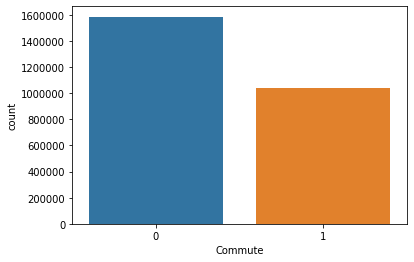

In [35]:
sns.countplot(x = 'Commute',data = train_df_weather)

### Compare Weekday and Weekend Activities

Text(0, 0.5, 'Avg Distance(mile)')

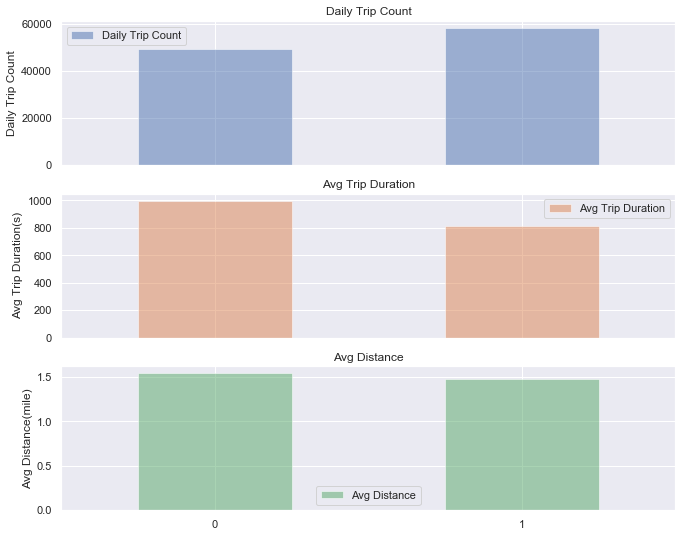

In [36]:
Weekday = train_df_weather[['Isweekday','trip_per_day','daily_avg_trip_duration','daily_avg_distance']]
Weekday.columns =  ['Isweekday','Daily Trip Count','Avg Trip Duration','Avg Distance']
Weekday = Weekday.groupby('Isweekday').agg('mean').reset_index()

sns.set(rc={'figure.figsize':(11, 4)})
cols_plot = ['Daily Trip Count','Avg Trip Duration','Avg Distance']
axes = Weekday[cols_plot].plot(kind='bar', alpha=0.5, linestyle='None', figsize=(11, 9), subplots=True,rot = 0)
axes[0].set_ylabel('Daily Trip Count')
axes[1].set_ylabel('Avg Trip Duration(s)')
axes[2].set_ylabel('Avg Distance(mile)')

### Check Rush Hours 

In [37]:
# Group by the start_hour and see the frequency correspond to each starting hour
train_df_weather.groupby('start_hour').count()[['trip_duration']].sort_values(by = 'trip_duration', ascending = False).head(6)

,trip_duration
start_hour,
17,265888
18,252466
8,217080
16,193695
19,175537
9,171875


In [38]:
# Top 50 stations on weekdays and weekends
top50_weekdays = train_df_weather.loc[train_df_weather['Isweekday']==1].groupby(['start_station_name']).\
agg({'trip_duration':'count','start_station_latitude':lambda x: x.iloc[0], 'start_station_longitude':lambda x: x.iloc[0]}).\
sort_values(by = 'trip_duration', ascending = False).head(50)

top50_weekends = train_df_weather.loc[train_df_weather['Isweekday']==0].groupby(['start_station_name']).\
agg({'trip_duration':'count','start_station_latitude':lambda x: x.iloc[0], 'start_station_longitude':lambda x: x.iloc[0]}).\
sort_values(by = 'trip_duration', ascending = False).head(50)

In [39]:
# Merge Dataset and export csv for Tableau Visualization
top50_weekdays['Isweekday'] =1
top50_weekends['Isweekday'] =0
top50_all_days = pd.concat([top50_weekdays,top50_weekends],axis = 0).reset_index()
top50_all_days.columns=['Station Name','Trip Count','Latitude','Longitude','Isweekday']
top50_all_days.to_csv('Top50_All_Days.csv')

In [40]:
# Top 50 start stations on weekdays during rush hours
top50_weekdays_rush_start = train_df_weather.loc[train_df_weather['Commute']==1].groupby(['start_station_name']).\
agg({'trip_duration':'mean','start_station_latitude':lambda x: x.iloc[0], 'start_station_longitude':lambda x: x.iloc[0]}).\
sort_values(by = 'trip_duration', ascending = False).head(50)
top50_weekdays_rush_start['Isstart'] =1
top50_weekdays_rush_start = top50_weekdays_rush_start.reset_index()
top50_weekdays_rush_start.columns=['Station Name','Trip Count','Latitude','Longitude','Isstart']

In [41]:
# Top 50 end stations on weekdays during rush hours
top50_weekdays_rush_end = train_df_weather.loc[train_df_weather['Commute']==1].groupby(['end_station_name']).\
agg({'trip_duration':'mean','end_station_latitude':lambda x: x.iloc[0], 'end_station_longitude':lambda x: x.iloc[0]}).\
sort_values(by = 'trip_duration', ascending = False).head(50)
top50_weekdays_rush_end['Isstart'] =0
top50_weekdays_rush_end.reset_index(inplace=True)
top50_weekdays_rush_end.columns=['Station Name','Trip Count','Latitude','Longitude','Isstart']

In [42]:
# Merge Dataset and export csv for Tableau Visualization
top50_rushhours = pd.concat([top50_weekdays_rush_start,top50_weekdays_rush_end],axis = 0)
top50_rushhours
top50_rushhours.to_csv('Top50_Rushhours.csv')

### Map for dock stations during weekdays and weekends

In [43]:
plt.figure(figsize=(15,10))
plt.plot(top50_weekdays['start_station_longitude'].values, top50_weekdays['start_station_latitude'].values, 'ro',alpha = 0.5,markersize=8)
plt.plot(top50_weekends['start_station_longitude'].values, top50_weekends['start_station_latitude'].values, 'bv',alpha = 0.5,markersize=8)
mplleaflet.display(tiles='cartodb_positron')

C:\Users\zhang\Anaconda3\lib\site-packages\IPython\core\display.py:694: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


In [44]:
# Top 50 start and end stations during commuting rush hours
plt.figure(figsize=(15,10))
plt.plot(top50_weekdays_rush_start['Longitude'].values, 
         top50_weekdays_rush_start['Latitude'].values, 'bv',alpha = 0.5,markersize=8)
plt.plot(top50_weekdays_rush_end['Longitude'].values, 
         top50_weekdays_rush_end['Latitude'].values, 'ro',alpha = 0.5,markersize=8)
mplleaflet.display(tiles='cartodb_positron')

### Check number of stations in different years

In [45]:
# Check number of stations in different years
train_df_weather.loc[train_df_weather.start_year == 2019].start_station_ID.nunique() 
train_df_weather.start_station_ID.nunique() 
# 2017 has 799, 2018 has 812, 2019 has 926, unique stations
# total of 1011 stations 
station_2017 = list(train_df_weather.loc[train_df_weather.start_year == 2017].start_station_ID.unique())
station_2018 = list(train_df_weather.loc[train_df_weather.start_year == 2018].start_station_ID.unique())
station_2019 = list(train_df_weather.loc[train_df_weather.start_year == 2019].start_station_ID.unique())
remove2018 =[item for item in station_2017 if item not in station_2018]
new2018 =[item for item in station_2018 if item not in station_2017]
remove2019 = [item for item in station_2018 if item not in station_2019]
new2019 =[item for item in station_2019 if item not in station_2018]
print('Number of stations removed in 2018: %.f' %len(remove2018))
print('Number of stations removed in 2019: %.f' %len(remove2019))
print('Number of stations added in 2018: %.f' %len(new2018))
print('Number of stations added in 2019: %.f' %len(new2019))

Number of stations removed in 2018: 40
Number of stations removed in 2019: 47
Number of stations added in 2018: 58
Number of stations added in 2019: 165


### Top 200 dock stations at all times 

In [46]:
Top200_ID = list(train_df_weather.groupby(['start_station_ID']).agg({'trip_duration':'count'}).\
sort_values(by='trip_duration',ascending=False).head(200).index)

In [47]:
Top200 = train_df_weather.loc[train_df_weather['start_station_ID'].isin(Top200_ID)]

In [48]:
# Impute missing values in tot_docks for top200 stations
missing = list(Top200.loc[Top200.tot_docks.isna()]['start_station_ID'].unique())
for i in missing:
    missingrows = len(Top200.loc[(Top200['start_station_ID']==i) & (Top200['tot_docks'].isna())])
    if len(Top200.loc[(Top200['start_station_ID']==i)]) != missingrows:
        mask =  (Top200['start_station_ID']==i) & (Top200['tot_docks'].isna())
        med = Top200.loc[(Top200['start_station_ID']==i)]['tot_docks'].median()
        Top200.loc[mask,'tot_docks']=Top200.loc[mask,'tot_docks'].fillna(med) 
Top200.loc[Top200.tot_docks.isna()]['start_station_ID'].nunique()

0

### Seasonal Trend 

In [49]:
# Time Series of Trip Count
daily_trip = train_df_weather[['start_date','trip_per_day','daily_avg_trip_duration','daily_avg_distance']].sort_values(by='start_date')
daily_trip.columns = ['Date','Daily Trip Count','Avg Trip Duration','Avg Distance']
daily_trip = daily_trip.groupby('Date').agg('mean').reset_index().set_index('Date')

Text(0, 0.5, 'Avg Distance(mile)')

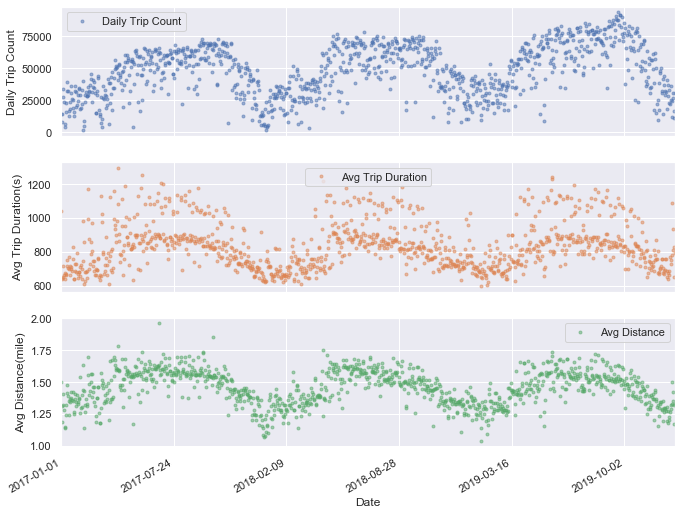

In [50]:
sns.set(rc={'figure.figsize':(11, 4)})
cols_plot = ['Daily Trip Count','Avg Trip Duration','Avg Distance']
axes = daily_trip[cols_plot].plot(marker='.', alpha=0.5, linestyle='None', figsize=(11, 9), subplots=True)
axes[0].set_ylabel('Daily Trip Count')
axes[1].set_ylabel('Avg Trip Duration(s)')
axes[2].set_ylabel('Avg Distance(mile)')

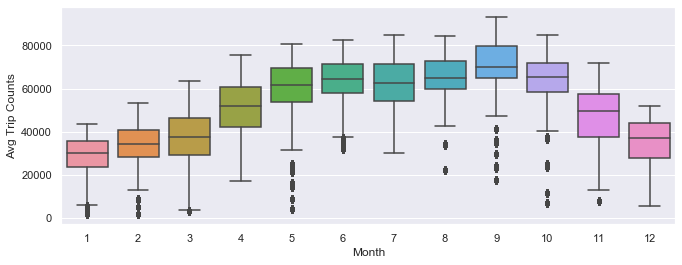

In [51]:
# Trip counts by month
month_trip = train_df_weather[['start_month','trip_per_day','daily_avg_trip_duration','daily_avg_distance']].sort_values(by='start_month')
month_trip.columns=['Month','Avg Trip Counts','Avg Trip Duration','Avg Distance'] 
sns.boxplot(x="Month", y="Avg Trip Counts", data=month_trip)

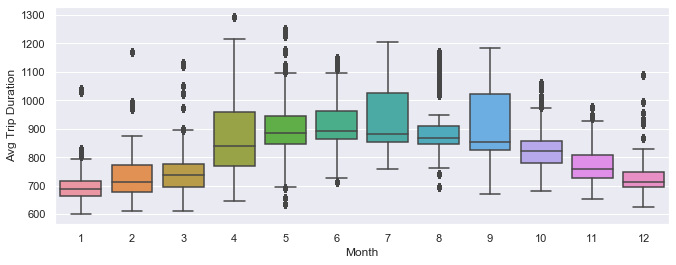

In [52]:
# Trip Duration by Month
sns.boxplot(x="Month", y="Avg Trip Duration",  data=month_trip)

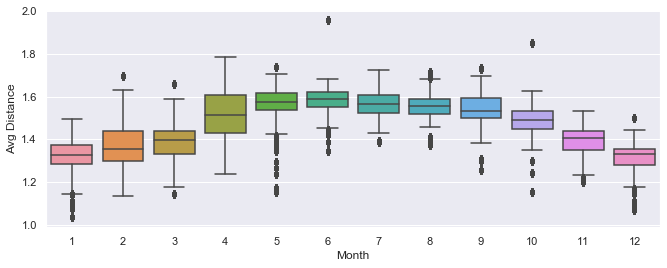

In [53]:
# Trip distance by Month
sns.boxplot(x="Month", y="Avg Distance", data=month_trip)

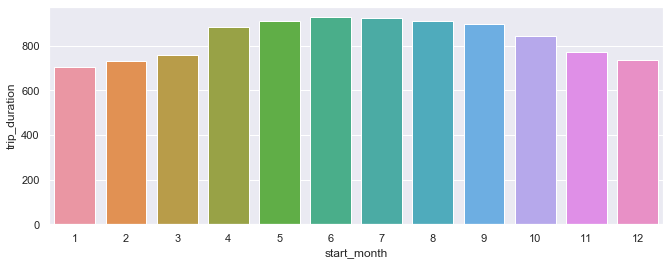

In [54]:
a = train_df_weather.groupby('start_month').mean()[['trip_duration']].reset_index()
sns.barplot(x = a.start_month, y = a.trip_duration)

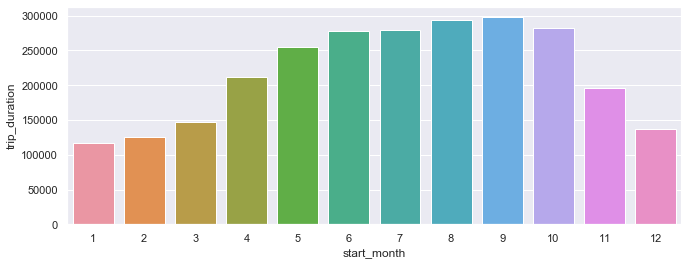

In [55]:
b = train_df_weather.groupby('start_month').count()[['trip_duration']].reset_index()
sns.barplot(x = b.start_month, y = b.trip_duration)

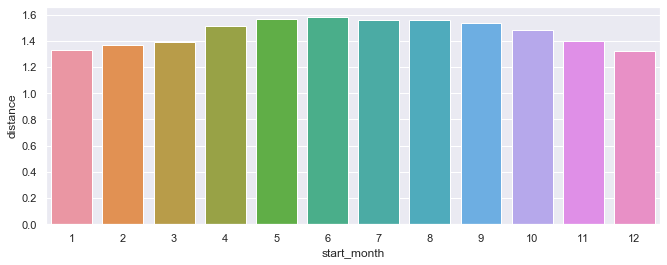

In [56]:
c = train_df_weather.groupby('start_month').mean()[['distance']].reset_index()
sns.barplot(x = c.start_month, y = c.distance)

## Weather Impact

### Temperature's impact on trip counts

[Text(0.5, 1.0, 'Trip Count per Day v.s. Average Temperature')]

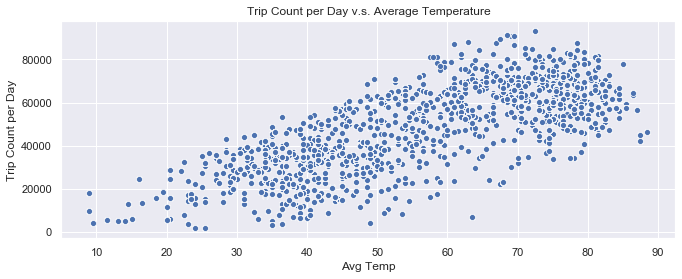

In [57]:
# Avg Temperature
TEMP = train_df_weather[['TAVG','trip_duration','trip_per_day','daily_avg_distance']]
TEMP.columns = ['Avg Temp','Avg Trip Duration(s)','Trip Count per Day','Avg Distance(mile)']
sns.scatterplot(x='Avg Temp',y='Trip Count per Day',data = TEMP).set(title = 'Trip Count per Day v.s. Average Temperature')


### Unusual Weather Condition's impact on Bike Count

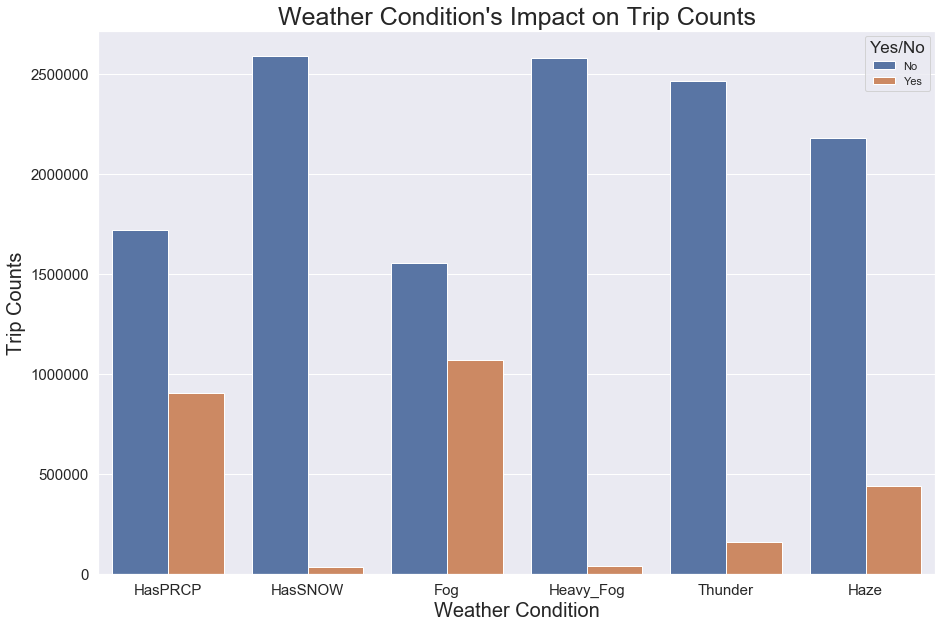

In [58]:
extreme_weather = train_df_weather[['HasPRCP','HasSNOW','Fog', 'Heavy_Fog', 'Thunder', 'Haze']].apply(pd.value_counts)
extreme_weather= extreme_weather.unstack().reset_index()
extreme_weather.columns=['Weather Condition','Yes/No','Trip Counts']
extreme_weather['Yes/No']=['Yes' if x==1 else 'No' for x in extreme_weather['Yes/No']]
plt.figure(figsize=(15,10))
plt.rcParams["axes.labelsize"] = 20
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.title("Weather Condition's Impact on Trip Counts", fontdict = {'fontsize' : 25})
sns.barplot(x='Weather Condition', y ='Trip Counts', hue ='Yes/No', data = extreme_weather)

### Correlation Heat Map

TypeError: object of type <class 'float'> cannot be safely interpreted as an integer.

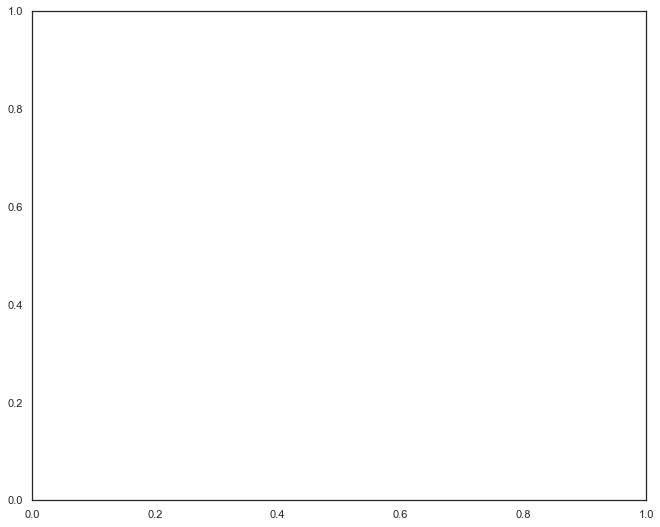

In [59]:
from string import ascii_letters
import numpy as np
import pandas as pd
import seaborn as sns 

sns.set(style="white")
corr =train_df_weather.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))
# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [ ]:
corr.to_csv('Correlation_Matrix.csv')

In [ ]:
corr.dtypes